In [1]:
!pip install wget torchinfo

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8b6f93717c0d8fb29af0326d0cd7d22486f3d26be1e7f47e7891044f95b5b18e
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip

!unzip -qq NCT-CRC-HE-100K.zip -d train
!unzip -qq CRC-VAL-HE-7K.zip -d val

print("dataset setup complete!")

--2025-02-23 09:55:58--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-02-23 09:55:59--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  18.5MB/s    in 10m 5s  

2025-02-23 10:06:04 (18.4 MB/s) - ‘NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]

--2025-02-23 10:06:04--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.o

In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

from glob import glob
import os
import cv2

In [92]:
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [93]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [32, 9]                   --
├─Conv2d: 1-1                                 [32, 32, 112, 112]        864
├─BatchNormAct2d: 1-2                         [32, 32, 112, 112]        64
│    └─Identity: 2-1                          [32, 32, 112, 112]        --
│    └─SiLU: 2-2                              [32, 32, 112, 112]        --
├─Sequential: 1-3                             [32, 320, 7, 7]           --
│    └─Sequential: 2-3                        [32, 16, 112, 112]        --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 16, 112, 112]        1,448
│    └─Sequential: 2-4                        [32, 24, 56, 56]          --
│    │    └─InvertedResidual: 3-2             [32, 24, 56, 56]          6,004
│    │    └─InvertedResidual: 3-3             [32, 24, 56, 56]          10,710
│    └─Sequential: 2-5                        [32, 40, 28, 28]          --
│    │   

In [94]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [32, 9]                   --
├─Conv2d: 1-1                                 [32, 32, 112, 112]        864
│    └─weight                                                           └─864
├─BatchNormAct2d: 1-2                         [32, 32, 112, 112]        64
│    └─weight                                                           ├─32
│    └─bias                                                             └─32
│    └─Identity: 2-1                          [32, 32, 112, 112]        --
│    └─SiLU: 2-2                              [32, 32, 112, 112]        --
├─Sequential: 1-3                             [32, 320, 7, 7]           --
│    └─0.0.conv_dw.weight                                               ├─288
│    └─0.0.bn1.weight                                                   ├─32
│    └─0.0.bn1.bias                                                     ├─32
│    

In [95]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [96]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = True  # 연산 속도를 희생하고 일관된 연산을 수행 -> SOTA: True로 변환

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [97]:
train_dir = './train/NCT-CRC-HE-100K'
test_7k_dir = './val/CRC-VAL-HE-7K'

In [98]:
from torch.utils.data import Dataset

# replace global_pool with 'max' to train the second model
GLOBAL_POOL = 'avg'


class Dataset(Dataset):
    def __init__(self, dir, aug=False):

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.aug = aug
        self.samples = [i for i in glob(os.path.join(dir, '**/*')) if os.path.isfile(i)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        class_name = os.path.basename(self.samples[idx]).split('-')[0]
        label = {
            'ADI': 0,
            'BACK': 1,
            'DEB': 2,
            'LYM': 3,
            'MUC': 4,
            'MUS': 5,
            'NORM': 6,
            'STR': 7,
            'TUM': 8,
        }

        img = cv2.imread(self.samples[idx], -1)[:, :, ::-1]
        img = np.float32(img) / 255.0

        if self.aug:
            if random.random() < 0.5:
                img = img[::-1]

            if random.random() < 0.5:
                img = img[:, ::-1]

            if random.random() < 0.3:
                if random.random() < 0.5:
                    img += np.random.normal(
                        0.0, np.random.uniform(0.01, 0.2),
                        (img.shape[0], img.shape[1], img.shape[2])
                    )
                else:
                    x = np.random.uniform(0.02, 0.15)
                    img += np.random.uniform(
                        -x, x,
                        (img.shape[0], img.shape[1], img.shape[2])
                    )

            if random.random() < 0.9:
                img += np.random.uniform(-0.15, 0.15, (1, 1, 3))
                img *= np.random.uniform(0.85, 1.15, (1, 1, 3))

            if random.random() < 0.3:
                kX, kY = np.random.randint(0, 4, 2) * 2 + 1
                if random.random() < 0.5:
                    img = cv2.GaussianBlur(img, (kX, kY), 0)
                else:
                    img = cv2.blur(img, (kX, kY))

        img = np.uint8(np.clip(img, 0, 1) * 255.0)
        img = self.transform(Image.fromarray(img))

        return img, label[class_name]

In [99]:
num_epochs = 30
batch_size = 32

In [100]:
dataset = Dataset(dir=train_dir, aug=True)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=False, drop_last=True)

In [101]:
test7k_dataset = Dataset(dir=test_7k_dir, aug=False)
test7k_dataloader = DataLoader(test7k_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=False, drop_last=False)

In [102]:
import json

with open("index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [103]:
train_data = Subset(dataset, load_train_idx)
val_data = Subset(dataset, load_val_idx)
test_data = Subset(dataset, load_test_idx)

In [104]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [113]:
optim = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-6)
loss_fn = torch.nn.CrossEntropyLoss()
best_acc = 0.0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [106]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [107]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [108]:
def evaluate(model, data_loader, criterion, device, phase="Validation", epoch=0):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [116]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [112]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, phase="Validation", epoch=epoch)


Epoch 1/30


Training: 100%|██████████| 2188/2188 [07:58<00:00,  4.57it/s]


Train Loss: 0.3783, Train Accuracy: 86.72%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.42it/s]


Validation Loss: 0.2509, Validation Accuracy: 91.19%
Balanced Accuracy: 0.9138

Epoch 2/30


Training: 100%|██████████| 2188/2188 [07:57<00:00,  4.58it/s]


Train Loss: 0.2538, Train Accuracy: 91.30%


Validation: 100%|██████████| 469/469 [01:24<00:00,  5.53it/s]


Validation Loss: 0.1906, Validation Accuracy: 93.65%
Balanced Accuracy: 0.9368

Epoch 3/30


Training: 100%|██████████| 2188/2188 [07:56<00:00,  4.59it/s]


Train Loss: 0.1986, Train Accuracy: 93.25%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.45it/s]


Validation Loss: 0.1933, Validation Accuracy: 93.71%
Balanced Accuracy: 0.9387

Epoch 4/30


Training: 100%|██████████| 2188/2188 [07:57<00:00,  4.58it/s]


Train Loss: 0.1659, Train Accuracy: 94.53%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.43it/s]


Validation Loss: 0.1408, Validation Accuracy: 95.27%
Balanced Accuracy: 0.9536

Epoch 5/30


Training: 100%|██████████| 2188/2188 [07:57<00:00,  4.58it/s]


Train Loss: 0.1424, Train Accuracy: 95.30%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.44it/s]


Validation Loss: 0.1385, Validation Accuracy: 95.48%
Balanced Accuracy: 0.9568

Epoch 6/30


Training: 100%|██████████| 2188/2188 [08:07<00:00,  4.49it/s]


Train Loss: 0.1266, Train Accuracy: 95.81%


Validation: 100%|██████████| 469/469 [01:28<00:00,  5.29it/s]


Validation Loss: 0.1241, Validation Accuracy: 95.99%
Balanced Accuracy: 0.9603

Epoch 7/30


Training: 100%|██████████| 2188/2188 [08:09<00:00,  4.47it/s]


Train Loss: 0.1136, Train Accuracy: 96.26%


Validation: 100%|██████████| 469/469 [01:28<00:00,  5.27it/s]


Validation Loss: 0.1253, Validation Accuracy: 96.04%
Balanced Accuracy: 0.9621

Epoch 8/30


Training: 100%|██████████| 2188/2188 [08:07<00:00,  4.49it/s]


Train Loss: 0.1038, Train Accuracy: 96.59%


Validation: 100%|██████████| 469/469 [01:27<00:00,  5.38it/s]


Validation Loss: 0.1099, Validation Accuracy: 96.57%
Balanced Accuracy: 0.9670

Epoch 9/30


Training: 100%|██████████| 2188/2188 [08:05<00:00,  4.51it/s]


Train Loss: 0.0940, Train Accuracy: 96.92%


Validation: 100%|██████████| 469/469 [01:27<00:00,  5.36it/s]


Validation Loss: 0.0846, Validation Accuracy: 97.47%
Balanced Accuracy: 0.9751

Epoch 10/30


Training: 100%|██████████| 2188/2188 [08:06<00:00,  4.50it/s]


Train Loss: 0.0866, Train Accuracy: 97.19%


Validation: 100%|██████████| 469/469 [01:27<00:00,  5.36it/s]


Validation Loss: 0.0999, Validation Accuracy: 96.95%
Balanced Accuracy: 0.9704

Epoch 11/30


Training: 100%|██████████| 2188/2188 [08:05<00:00,  4.51it/s]


Train Loss: 0.0811, Train Accuracy: 97.42%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.43it/s]


Validation Loss: 0.0903, Validation Accuracy: 97.14%
Balanced Accuracy: 0.9726

Epoch 12/30


Training: 100%|██████████| 2188/2188 [07:56<00:00,  4.59it/s]


Train Loss: 0.0733, Train Accuracy: 97.64%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.51it/s]


Validation Loss: 0.0840, Validation Accuracy: 97.41%
Balanced Accuracy: 0.9750

Epoch 13/30


Training: 100%|██████████| 2188/2188 [07:55<00:00,  4.60it/s]


Train Loss: 0.0690, Train Accuracy: 97.70%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.52it/s]


Validation Loss: 0.0870, Validation Accuracy: 97.20%
Balanced Accuracy: 0.9724

Epoch 14/30


Training: 100%|██████████| 2188/2188 [07:55<00:00,  4.61it/s]


Train Loss: 0.0647, Train Accuracy: 97.84%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.46it/s]


Validation Loss: 0.0855, Validation Accuracy: 97.25%
Balanced Accuracy: 0.9728

Epoch 15/30


Training: 100%|██████████| 2188/2188 [07:54<00:00,  4.62it/s]


Train Loss: 0.0616, Train Accuracy: 97.99%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.50it/s]


Validation Loss: 0.0753, Validation Accuracy: 97.73%
Balanced Accuracy: 0.9772

Epoch 16/30


Training: 100%|██████████| 2188/2188 [07:59<00:00,  4.57it/s]


Train Loss: 0.0546, Train Accuracy: 98.17%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.45it/s]


Validation Loss: 0.0960, Validation Accuracy: 96.93%
Balanced Accuracy: 0.9695

Epoch 17/30


Training: 100%|██████████| 2188/2188 [08:06<00:00,  4.50it/s]


Train Loss: 0.0538, Train Accuracy: 98.22%


Validation: 100%|██████████| 469/469 [01:27<00:00,  5.35it/s]


Validation Loss: 0.0972, Validation Accuracy: 97.04%
Balanced Accuracy: 0.9708

Epoch 18/30


Training: 100%|██████████| 2188/2188 [07:59<00:00,  4.56it/s]


Train Loss: 0.0520, Train Accuracy: 98.27%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.41it/s]


Validation Loss: 0.0678, Validation Accuracy: 97.87%
Balanced Accuracy: 0.9790

Epoch 19/30


Training: 100%|██████████| 2188/2188 [07:58<00:00,  4.57it/s]


Train Loss: 0.0477, Train Accuracy: 98.44%


Validation: 100%|██████████| 469/469 [01:24<00:00,  5.52it/s]


Validation Loss: 0.0795, Validation Accuracy: 97.49%
Balanced Accuracy: 0.9755

Epoch 20/30


Training: 100%|██████████| 2188/2188 [07:57<00:00,  4.59it/s]


Train Loss: 0.0449, Train Accuracy: 98.51%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.42it/s]


Validation Loss: 0.0639, Validation Accuracy: 98.13%
Balanced Accuracy: 0.9816

Epoch 21/30


Training: 100%|██████████| 2188/2188 [08:00<00:00,  4.55it/s]


Train Loss: 0.0444, Train Accuracy: 98.54%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.48it/s]


Validation Loss: 0.0656, Validation Accuracy: 97.93%
Balanced Accuracy: 0.9801

Epoch 22/30


Training: 100%|██████████| 2188/2188 [08:00<00:00,  4.56it/s]


Train Loss: 0.0407, Train Accuracy: 98.62%


Validation: 100%|██████████| 469/469 [01:26<00:00,  5.42it/s]


Validation Loss: 0.0678, Validation Accuracy: 98.04%
Balanced Accuracy: 0.9804

Epoch 23/30


Training: 100%|██████████| 2188/2188 [08:00<00:00,  4.56it/s]


Train Loss: 0.0399, Train Accuracy: 98.68%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.46it/s]


Validation Loss: 0.0794, Validation Accuracy: 97.74%
Balanced Accuracy: 0.9782

Epoch 24/30


Training: 100%|██████████| 2188/2188 [07:59<00:00,  4.56it/s]


Train Loss: 0.0373, Train Accuracy: 98.75%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.46it/s]


Validation Loss: 0.0733, Validation Accuracy: 97.95%
Balanced Accuracy: 0.9805

Epoch 25/30


Training: 100%|██████████| 2188/2188 [07:59<00:00,  4.56it/s]


Train Loss: 0.0369, Train Accuracy: 98.74%


Validation: 100%|██████████| 469/469 [01:24<00:00,  5.52it/s]


Validation Loss: 0.0681, Validation Accuracy: 98.13%
Balanced Accuracy: 0.9812

Epoch 26/30


Training: 100%|██████████| 2188/2188 [07:56<00:00,  4.59it/s]


Train Loss: 0.0340, Train Accuracy: 98.84%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.48it/s]


Validation Loss: 0.0643, Validation Accuracy: 98.11%
Balanced Accuracy: 0.9818

Epoch 27/30


Training: 100%|██████████| 2188/2188 [07:57<00:00,  4.58it/s]


Train Loss: 0.0332, Train Accuracy: 98.87%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.45it/s]


Validation Loss: 0.0743, Validation Accuracy: 97.93%
Balanced Accuracy: 0.9793

Epoch 28/30


Training: 100%|██████████| 2188/2188 [07:55<00:00,  4.60it/s]


Train Loss: 0.0317, Train Accuracy: 98.95%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.48it/s]


Validation Loss: 0.0629, Validation Accuracy: 98.06%
Balanced Accuracy: 0.9815

Epoch 29/30


Training: 100%|██████████| 2188/2188 [07:55<00:00,  4.60it/s]


Train Loss: 0.0296, Train Accuracy: 99.03%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.50it/s]


Validation Loss: 0.0652, Validation Accuracy: 98.18%
Balanced Accuracy: 0.9820

Epoch 30/30


Training: 100%|██████████| 2188/2188 [07:55<00:00,  4.60it/s]


Train Loss: 0.0305, Train Accuracy: 98.97%


Validation: 100%|██████████| 469/469 [01:25<00:00,  5.49it/s]

Validation Loss: 0.0974, Validation Accuracy: 97.20%
Balanced Accuracy: 0.9730


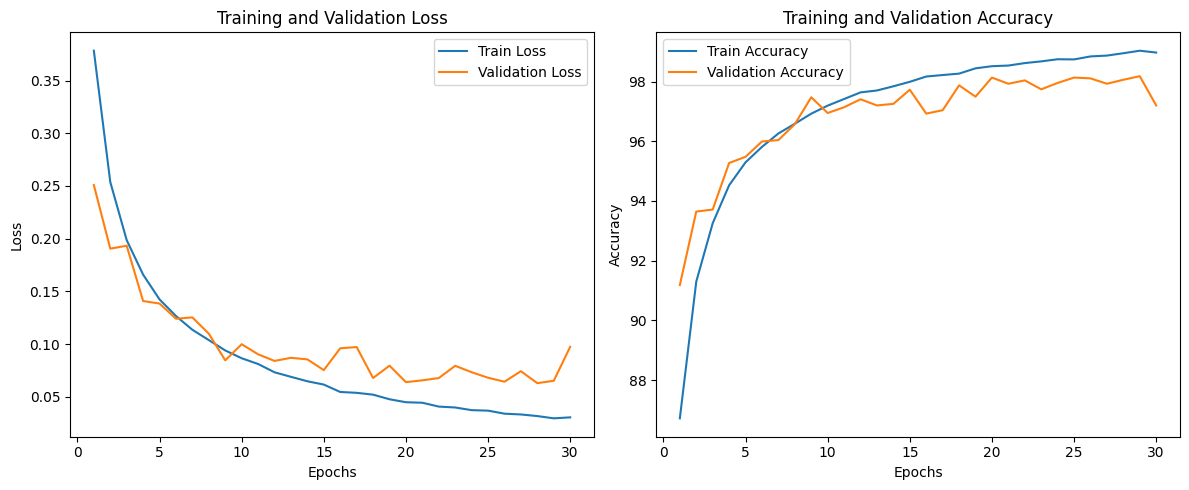

In [114]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [117]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 11.32 ms
Standard Deviation: 0.45 ms
Maximum Time: 17.12 ms
Minimum Time: 10.80 ms


In [118]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [01:25<00:00,  5.46it/s]

Test Loss: 0.0996, Test Accuracy: 97.24%
Balanced Accuracy: 0.9735


In [122]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::conv2d         2.32%     351.729us        53.89%       8.156ms     100.697us       0.000us         0.00%       3.902ms      48.170us            81  
                                      aten::convolution         3.05%     461.786us        51.57%       7.805ms      96.355us       0.000us         0.00%       3.902ms      48.170us            81  
         

In [127]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    val_losses = []
    val_accuracies = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [128]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [129]:
print("\n 7K Final Test Evaluation")
evaluate(model,test7k_dataloader, criterion, device, phase="Test")


 7K Final Test Evaluation


Test: 100%|██████████| 225/225 [00:06<00:00, 35.66it/s]

Test Loss: 0.4784, Test Accuracy: 90.03%
Balanced Accuracy: 0.8733


In [130]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test7k_dataloader, loss_fn, device, phase="Test")

Test: 100%|██████████| 225/225 [00:06<00:00, 34.14it/s]

Test Loss: 0.4784, Test Accuracy: 90.03%
Overall - F1: 0.8590, Recall: 0.8733, Precision: 0.8686
Per-Class Metrics:
Class 0 - F1: 0.9709, Recall: 0.9469, Precision: 0.9961
Class 1 - F1: 0.9895, Recall: 0.9976, Precision: 0.9814
Class 2 - F1: 0.7293, Recall: 0.9853, Precision: 0.5789
Class 3 - F1: 0.7682, Recall: 0.6246, Precision: 0.9975
Class 4 - F1: 0.9489, Recall: 0.9768, Precision: 0.9224
Class 5 - F1: 0.7879, Recall: 0.8345, Precision: 0.7462
Class 6 - F1: 0.9482, Recall: 0.9879, Precision: 0.9116
Class 7 - F1: 0.6372, Recall: 0.5819, Precision: 0.7040
Class 8 - F1: 0.9512, Recall: 0.9246, Precision: 0.9794


<Figure size 2000x1200 with 0 Axes>

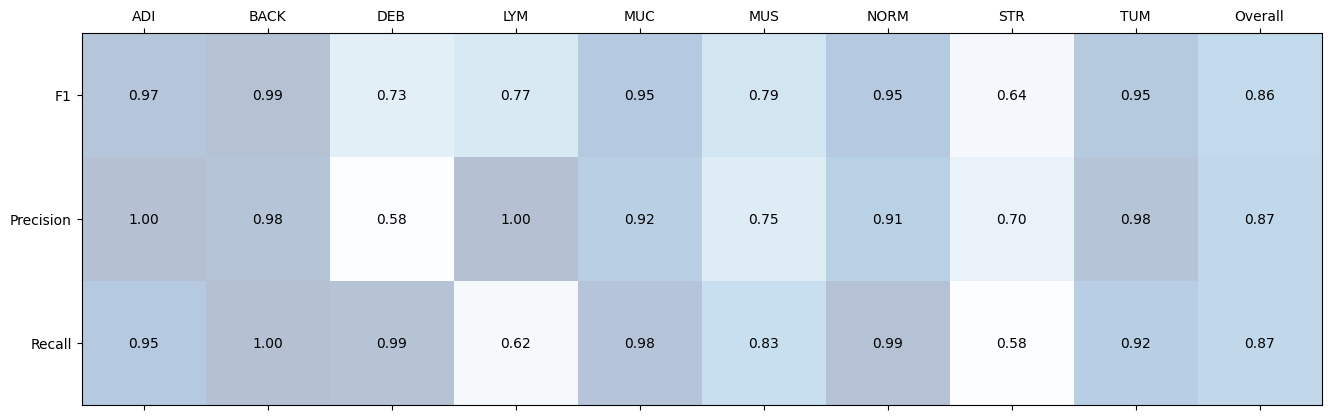

In [131]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )